In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from Bio import SeqIO
import bioframe
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
os.environ['CUDA_VISIBLE_DEVICES']='5'

### Short seq clustering (30nt) function of 1M nucleotides

In [2]:
strand = '+'
#genome = SeqIO.to_dict(SeqIO.parse("/home/amber/multitask_RNA/data/GPN_plant/TAIR10.fa", format="fasta"))
genome = SeqIO.to_dict(SeqIO.parse("/home/amber/ref/hg38/hg38.fa", format="fasta"))
window_size = 1000000
center =  69761578
seq = genome["chr8"][center-window_size//2:center+window_size//2].seq
if strand == "+":
    print("Positive strand")
elif strand == "-":
    print("Negative strand")
    print(seq[:10])
    seq = seq.reverse_complement()
    print(seq[:10])
seq = str(seq)

gtf = pd.read_csv(
    #"/home/amber/multitask_RNA/data/GPN_plant/Arabidopsis_thaliana.TAIR10.54.chromosome.5.gff3.gz",
    "/home/amber/multitask_RNA/data/annotation/gencode.v40.annotation.gtf",
    sep='\t', header=None, comment="#",
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'],
)
gtf.chrom = gtf.chrom.astype(str)
gtf = gtf[gtf.chrom.isin(["Chr8", "chr8", "8"])]
gtf.shape

Positive strand


(120823, 9)

In [3]:
gtf

,chrom,source,feature,start,end,score,strand,frame,attribute
1357716,chr8,HAVANA,gene,64091,64320,.,-,.,"gene_id ""ENSG00000253620.2""; gene_type ""proces..."
1357717,chr8,HAVANA,transcript,64091,64320,.,-,.,"gene_id ""ENSG00000253620.2""; transcript_id ""EN..."
1357718,chr8,HAVANA,exon,64269,64320,.,-,.,"gene_id ""ENSG00000253620.2""; transcript_id ""EN..."
1357719,chr8,HAVANA,exon,64091,64175,.,-,.,"gene_id ""ENSG00000253620.2""; transcript_id ""EN..."
1357720,chr8,HAVANA,gene,72601,79775,.,+,.,"gene_id ""ENSG00000253896.3""; gene_type ""lncRNA..."
...,...,...,...,...,...,...,...,...,...
1478534,chr8,HAVANA,transcript,145052468,145053437,.,+,.,"gene_id ""ENSG00000182307.14""; transcript_id ""E..."
1478535,chr8,HAVANA,exon,145052468,145052585,.,+,.,"gene_id ""ENSG00000182307.14""; transcript_id ""E..."
1478536,chr8,HAVANA,exon,145052747,145052897,.,+,.,"gene_id ""ENSG00000182307.14""; transcript_id ""E..."
1478537,chr8,HAVANA,exon,145053062,145053146,.,+,.,"gene_id ""ENSG00000182307.14""; transcript_id ""E..."


In [4]:
# To work with the already computed 1Mb embeddings
gtf = gtf[(gtf.start > center-window_size//2) & (gtf.end < center+window_size//2)]
gtf.loc[:,'start'] = gtf.start-(center-window_size//2)
gtf.loc[:,'end'] = gtf.end-(center-window_size//2)
gtf_exon = gtf[gtf.feature=="exon"]
gtf_exon["transcript_id"] = gtf_exon.attribute.str.split(";").str[0].str.split(":").str[-1]
gtf_exon.transcript_id.value_counts()

/tmp/ipykernel_651945/3694044482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf.loc[:,'start'] = gtf.start-(center-window_size//2)
/tmp/ipykernel_651945/3694044482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf.loc[:,'end'] = gtf.end-(center-window_size//2)
/tmp/ipykernel_651945/3694044482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

gene_id "ENSG00000137573.14"    189
gene_id "ENSG00000140396.13"     61
gene_id "ENSG00000137571.11"     45
gene_id "ENSG00000253479.6"      18
gene_id "ENSG00000246528.4"      10
gene_id "ENSG00000147596.4"      10
gene_id "ENSG00000254557.1"       3
gene_id "ENSG00000247570.2"       3
gene_id "ENSG00000222889.1"       1
gene_id "ENSG00000271113.1"       1
gene_id "ENSG00000277740.1"       1
gene_id "ENSG00000253216.1"       1
gene_id "ENSG00000239580.3"       1
gene_id "ENSG00000223293.1"       1
gene_id "ENSG00000280393.1"       1
gene_id "ENSG00000253721.1"       1
gene_id "ENSG00000212473.1"       1
gene_id "ENSG00000253173.3"       1
gene_id "ENSG00000255107.1"       1
Name: transcript_id, dtype: int64

In [5]:
import more_itertools

def get_transcript_introns(df_transcript):
    df_transcript = df_transcript.sort_values("start")
    exon_pairs = more_itertools.pairwise(df_transcript.loc[:, ["start", "end"]].values)
    introns = [[e1[1], e2[0]] for e1, e2 in exon_pairs]
    introns = pd.DataFrame(introns, columns=["start", "end"])
    introns["chrom"] = df_transcript.chrom.iloc[0]
    return introns

In [6]:
gtf_introns = gtf_exon.groupby("transcript_id").apply(get_transcript_introns).reset_index().drop_duplicates(subset=["chrom", "start", "end"])
gtf_introns["feature"] = "intron"
print(gtf_introns.shape)
gtf = pd.concat([gtf, gtf_introns], ignore_index=True)
print(gtf.shape)

(196, 6)
(926, 11)


In [7]:
gtf.feature.value_counts()

exon           350
intron         196
CDS            186
UTR             82
transcript      60
start_codon     20
gene            18
stop_codon      14
Name: feature, dtype: int64

In [8]:
gtf.chrom = gtf.chrom.astype(str)
gtf.start = gtf.start.astype(int)
gtf.end = gtf.end.astype(int)


In [9]:
for index,row in gtf.iterrows():
    if row['start'] < row['end']:
        next
    else:
        gtf.loc[index,'end'] = row['start']
        gtf.loc[index,'start'] = row['end']
features_of_interest = ['exon','intron']

In [10]:
W = 30#50
windows = pd.DataFrame(dict(start=np.arange(0+10000, window_size-W-10000, W)))
windows["end"] = windows.start + W
windows["chrom"] = gtf.chrom.iloc[0] #"5"

for f in features_of_interest:
    windows = bioframe.coverage(windows, gtf[gtf.feature==f])
    windows.rename(columns=dict(coverage=f), inplace=True)
windows

,start,end,chrom,exon,intron
0,10000,10030,chr8,0,0
1,10030,10060,chr8,0,0
2,10060,10090,chr8,0,0
3,10090,10120,chr8,0,0
4,10120,10150,chr8,0,0
...,...,...,...,...,...
32661,989830,989860,chr8,0,0
32662,989860,989890,chr8,0,0
32663,989890,989920,chr8,0,0
32664,989920,989950,chr8,0,0


In [11]:
windows["Region"]= np.nan
windows.loc[windows[features_of_interest].sum(axis=1)==0, "Region"] = "Intergenic"
windows.loc[(windows.exon==0)&(windows.intron==W), "Region"] = "Intron"
windows.loc[(windows.exon==W)&(windows.intron==0), "Region"] = "Exon"
print(windows.Region.value_counts())
windows.dropna(inplace=True)
print(windows.shape)

Intron        17437
Intergenic    13798
Exon            528
Name: Region, dtype: int64
(31763, 6)


In [12]:
projector = Pipeline([
    ("scaler", StandardScaler()),  # not sure it's a good idea. yeah, they have very different variances.
    #("pca", PCA(n_components=10)),
    ("umap", UMAP()),  # default n_neighbors works well
])

## Conveformer-human

## GPN-finetune human

In [13]:
from transformers import AutoModel,AutoTokenizer
from tqdm import tqdm
import torch
import gpn.mlm
#gonzalobenegas/gpn-arabidopsis
model = AutoModel.from_pretrained("/home/amber/multitask_RNA/model/GPN_finetune/checkpoint-2000000").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("/home/amber/multitask_RNA/model/GPN_finetune/checkpoint-2000000")
model.eval();

Some weights of the model checkpoint at /home/amber/multitask_RNA/model/GPN_finetune/checkpoint-2000000 were not used when initializing ConvNetModel: ['cls.decoder.3.weight', 'cls.decoder.2.weight', 'cls.decoder.3.bias', 'cls.decoder.0.weight', 'cls.decoder.2.bias', 'cls.decoder.0.bias']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
input_ids = tokenizer(seq, return_tensors="pt")["input_ids"]
input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')
with torch.no_grad():
    embedding = model(input_ids=input_ids).last_hidden_state[0].cpu().detach().numpy()
print(embedding.shape)

/tmp/ipykernel_411856/4131456971.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')


(1000000, 512)


In [15]:
embedding_cols = np.arange(embedding.shape[1])
windows.loc[:, embedding_cols] = windows.apply(
    lambda row: embedding[row.start:row.end].sum(axis=0),
    axis=1,
    result_type="expand",
)
windows

,start,end,chrom,exon,intron,Region,0,1,2,3,...,502,503,504,505,506,507,508,509,510,511
0,10000,10030,chr8,0,0,Intergenic,39.344830,-68.014801,-67.886703,-41.809010,...,-54.284225,-83.026283,-32.626144,-87.124367,-78.083336,86.429390,-1.286166,-43.652687,-49.016251,-49.765125
1,10030,10060,chr8,0,0,Intergenic,47.230194,-35.788452,-75.744904,-56.860016,...,14.268832,-30.416670,-24.408112,-103.086403,-95.130875,287.839630,2.059177,-55.252571,-86.157982,5.539605
2,10060,10090,chr8,0,0,Intergenic,-31.773495,-38.605305,-104.465675,-7.510530,...,-67.330505,-47.083031,-23.843908,-103.741798,-81.513252,43.388573,8.668710,-74.883446,-123.174202,8.068228
3,10090,10120,chr8,0,0,Intergenic,-27.917841,10.307426,-84.473679,-38.778061,...,-44.872131,-83.900337,-32.100979,-18.716816,-64.099579,155.403412,-21.244282,-78.826080,-110.686417,-47.909050
4,10120,10150,chr8,0,0,Intergenic,-12.182234,-9.515257,-81.842941,-17.474861,...,-6.336311,-90.959229,-32.481113,-50.420391,-70.358795,115.561676,-40.346016,-66.388092,-104.024582,-43.285595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,chr8,0,0,Intergenic,20.372948,-43.936981,-102.407295,-6.188968,...,11.557027,-54.078259,-71.027603,-72.653351,-72.851952,376.160980,4.448153,-70.190483,-89.960205,-7.542210
32662,989860,989890,chr8,0,0,Intergenic,35.190029,-42.872669,-104.283195,8.247149,...,-54.182308,-74.463692,-34.053036,-79.938164,-88.648575,236.345200,-47.643970,-67.881226,-102.799973,-44.876713
32663,989890,989920,chr8,0,0,Intergenic,22.874380,-46.462051,-94.048752,-17.716711,...,-17.659275,-38.033916,-59.579990,-92.431412,-80.118004,215.400253,-37.243744,-88.911240,-104.480331,-35.321247
32664,989920,989950,chr8,0,0,Intergenic,73.772697,-47.170334,-86.590210,0.670032,...,-17.653402,-38.555466,-54.418224,-87.811073,-64.606628,339.722900,-33.817062,-65.718605,-101.780769,-35.358837


In [16]:
intron_index = windows.index[windows['Region'] == 'Intron']
exon_index = windows.index[windows['Region'] == 'Exon']
nongene_index = windows.index[windows['Region'] == 'Intergenic']
selected_index = []
selected_index.extend(random.sample(list(intron_index),len(exon_index)))
selected_index.extend(random.sample(list(nongene_index), len(exon_index)))
selected_index.extend(exon_index)
selected_df = windows.loc[selected_index]
selected_df[['UMAP1','UMAP2']]= projector.fit_transform(selected_df[embedding_cols])


In [17]:
windows[['UMAP1','UMAP2']]= projector.fit_transform(windows[embedding_cols])

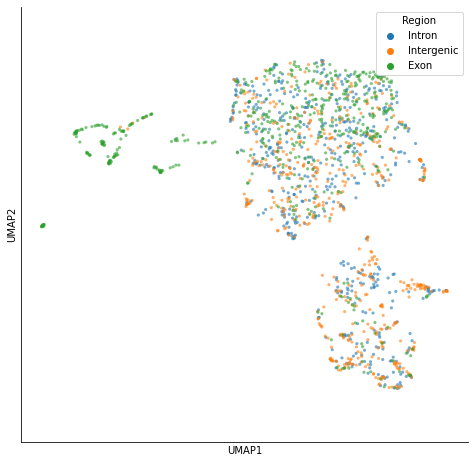

In [18]:

region_order = ["Intron", "Intergenic", "Exon"]


plt.figure(figsize=(8, 8))
g = sns.scatterplot(
    data=selected_df,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=10,
    linewidth=0,
    alpha = 0.6
    #,palette=['red','grey','grey']
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');

## GPN plant

In [19]:
from transformers import AutoModel,AutoTokenizer
from tqdm import tqdm
import torch
import gpn.mlm
#gonzalobenegas/gpn-arabidopsis
model = AutoModel.from_pretrained("gonzalobenegas/gpn-arabidopsis").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("gonzalobenegas/gpn-arabidopsis")
model.eval();

Some weights of the model checkpoint at gonzalobenegas/gpn-arabidopsis were not used when initializing ConvNetModel: ['cls.decoder.2.weight', 'cls.decoder.0.bias', 'cls.decoder.2.bias', 'cls.decoder.0.weight', 'cls.decoder.3.bias', 'cls.decoder.3.weight']
- This IS expected if you are initializing ConvNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
input_ids = tokenizer(seq, return_tensors="pt")["input_ids"]
input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')
with torch.no_grad():
    embedding = model(input_ids=input_ids).last_hidden_state[0].cpu().detach().numpy()
print(embedding.shape)

/tmp/ipykernel_3409576/4131456971.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(tokenizer(seq, return_tensors="pt")["input_ids"]).to('cuda')


(1000000, 512)


In [21]:
embedding_cols = np.arange(embedding.shape[1])
windows.loc[:, embedding_cols] = windows.apply(
    lambda row: embedding[row.start:row.end].sum(axis=0),
    axis=1,
    result_type="expand",
)
windows

,start,end,chrom,exon,intron,Region,0,1,2,3,...,504,505,506,507,508,509,510,511,UMAP1,UMAP2
0,10000,10030,5,30,0,Exon,-48.961449,-63.756786,-79.799095,26.134405,...,48.961754,9.088400,-29.905354,310.675476,-47.294319,-10.411341,27.999592,-38.705223,6.310245,5.940547
1,10030,10060,5,30,0,Exon,22.708603,-49.225742,-113.027664,106.359879,...,60.506435,8.232245,-2.889455,475.941132,-37.083584,-33.975868,53.104294,-25.445915,6.095331,5.796391
2,10060,10090,5,30,0,Exon,20.599089,-45.212002,-78.906670,60.311951,...,49.780499,59.819389,-5.799135,881.034973,-11.685690,-47.682816,32.639793,-25.564516,5.995388,4.256288
3,10090,10120,5,30,0,Exon,11.153436,-67.887665,-92.123322,73.489899,...,67.729607,51.001709,-2.956552,209.109192,18.920111,-32.746365,48.113777,-116.764107,4.501987,4.328297
5,10150,10180,5,0,30,Intron,144.699371,-43.017380,-49.480209,15.785836,...,30.211857,68.393387,-24.328062,387.328491,126.316811,-86.303879,-73.462334,-76.726883,3.625918,2.392498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32660,989800,989830,5,30,0,Exon,12.587675,-56.231411,-153.121857,29.715536,...,-23.582113,-72.416267,-61.260708,261.772308,30.333395,-65.530899,-59.721527,-104.500420,4.447525,4.901198
32662,989860,989890,5,0,30,Intron,-37.413841,-62.575211,-103.329292,-0.974684,...,-23.640785,-63.713646,-34.590130,81.568085,124.983009,-92.901405,-110.781044,-88.596092,3.341586,2.637041
32663,989890,989920,5,0,30,Intron,-7.800569,-87.884064,-75.737373,-46.710930,...,-31.128807,-41.033092,-57.393806,202.551971,142.914185,-51.914768,-98.326729,-110.582886,3.229840,4.224863
32664,989920,989950,5,0,30,Intron,-36.852409,-73.202637,-74.193787,-35.518963,...,-14.446087,-37.793655,-68.865097,208.253326,135.171402,-52.254765,-93.020340,-105.591927,2.891954,4.054171


In [22]:
intron_index = windows.index[windows['Region'] == 'Intron']
exon_index = windows.index[windows['Region'] == 'Exon']
nongene_index = windows.index[windows['Region'] == 'Intergenic']

In [23]:
import random
selected_index = []
selected_index.extend(random.sample(list(intron_index),len(exon_index)))
selected_index.extend(random.sample(list(nongene_index), len(exon_index)))
selected_index.extend(exon_index)
selected_df = windows.loc[selected_index]

ValueError: Sample larger than population or is negative

In [24]:
windows[['UMAP1','UMAP2']]= projector.fit_transform(windows[embedding_cols])

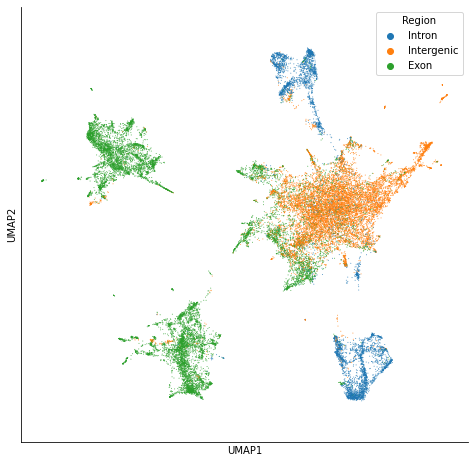

In [25]:

region_order = ["Intron", "Intergenic", "Exon"]


plt.figure(figsize=(8, 8))
g = sns.scatterplot(
    data=windows,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=1,
    linewidth=0,
    alpha = 0.8
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');

## Roberta 6-mer full size

In [12]:
from transformers import RobertaForMaskedLM
from tqdm import tqdm
import torch
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/home/amber/multitask_RNA/rna_self_train/')
from dna_tokenizer import DNATokenizer

import wandb
api = wandb.Api()
artifact = api.artifact('ambert/rna_MLM/model-1ucnnxtc:v0')
artifact.download('./rna_self_train/wandb/kmer_full_roberta/')
model = RobertaForMaskedLM.from_pretrained('./rna_self_train/wandb/kmer_full_roberta/',
                            output_hidden_states=True).to('cuda')
tokenizer = DNATokenizer('/home/amber/multitask_RNA/rna_self_train/vocab.txt')

wandb: Downloading large artifact model-1ucnnxtc:v0, 340.33MB. 3 files... Done. 0:0:0


In [37]:
seq = seq.upper()
split_seq = ' '.join(seq[i*6 +4 :(i+1)*6 +4] for i in range(0, int(len(seq)/6)))
token_seq = tokenizer.batch_encode_plus([split_seq],context_split=True,
                                        add_special_tokens=True,max_length=512,
                                        return_tensors='pt')

In [40]:
model_output = []
for seq_i in tqdm(range(0,len(token_seq['input_ids']),30)):
        seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+30]).to('cuda')
        output_seq = model(seq_batch)[-1][-1].cpu().detach().numpy()
        model_output.extend(output_seq)
        
model_output=np.array(model_output)
print(model_output.shape)

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_3433228/1029664993.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq_batch = torch.tensor(token_seq['input_ids'][seq_i:seq_i+30]).to('cuda')
100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

(327, 512, 768)


In [41]:
cropped_output = model_output[:,1:-1,:]
cropped_output = cropped_output.reshape(327*510,768)

In [42]:
embedding_cols = np.arange(cropped_output.shape[1])
windows.loc[:, embedding_cols] = windows.apply(
    lambda row: cropped_output[int((row.start-4)/6):int((row.end-4)/6)].sum(axis=0),
    axis=1,
    result_type="expand",
)
windows

,start,end,chrom,exon,intron,Region,0,1,2,3,...,760,761,762,763,764,765,766,767,UMAP1,UMAP2
0,10000,10030,chr5,0,0,Intergenic,-1.490494,-1.977860,2.127181,-2.501952,...,-1.048092,0.193559,-0.488298,10.151764,2.453330,-4.149757,-2.937164,11.131172,9.624854,4.560971
1,10030,10060,chr5,0,0,Intergenic,0.930931,-2.106084,5.027813,2.179677,...,0.502210,-7.938819,0.281496,1.880496,0.839233,-8.030745,-2.421092,3.142423,8.832930,3.561200
2,10060,10090,chr5,0,0,Intergenic,-1.395078,-2.004637,1.638133,-0.964531,...,-0.080604,-3.005923,0.486779,3.135513,-4.327659,-11.098793,2.246946,9.580665,9.839597,4.851090
3,10090,10120,chr5,0,0,Intergenic,-0.967767,1.324699,1.420357,-0.871627,...,0.443808,-4.431107,-3.916008,4.703404,-0.038982,-2.503868,-0.043558,11.578344,9.793847,4.590623
4,10120,10150,chr5,0,0,Intergenic,0.119328,0.485926,1.220527,1.555112,...,-2.428122,-3.357616,-1.836862,5.526284,-1.357697,-1.813196,-1.575194,5.392697,9.610203,4.609939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,989830,989860,chr5,0,0,Intergenic,2.630226,-0.108808,2.250723,2.345901,...,3.124548,-2.359704,-6.037603,3.821539,-2.928796,1.480493,0.525273,12.043459,11.736036,3.737146
32662,989860,989890,chr5,0,0,Intergenic,4.037793,-4.549010,1.754624,-5.197404,...,2.560351,-5.651991,-3.096498,-4.726510,0.343782,0.524534,-2.664146,6.007436,12.027954,3.880320
32663,989890,989920,chr5,0,0,Intergenic,3.778594,-2.770371,1.541003,-0.925608,...,1.269503,-2.619141,-2.754986,-1.158836,2.158396,-0.740103,-2.532096,6.857088,12.076064,3.898988
32664,989920,989950,chr5,0,0,Intergenic,4.196397,-2.099912,3.014350,-1.096400,...,2.106622,-3.764705,0.982838,-1.497055,2.509770,0.040815,-5.593967,7.632037,12.092677,3.903756


In [43]:
intron_index = windows.index[windows['Region'] == 'Intron']
exon_index = windows.index[windows['Region'] == 'Exon']
nongene_index = windows.index[windows['Region'] == 'Intergenic']
selected_index = []
selected_index.extend(random.sample(list(intron_index),len(exon_index)))
selected_index.extend(random.sample(list(nongene_index), len(exon_index)))
selected_index.extend(exon_index)
selected_df = windows.loc[selected_index]
selected_df[['UMAP1','UMAP2']]= projector.fit_transform(selected_df[embedding_cols])


In [25]:
windows[['UMAP1','UMAP2']]= projector.fit_transform(windows[embedding_cols])

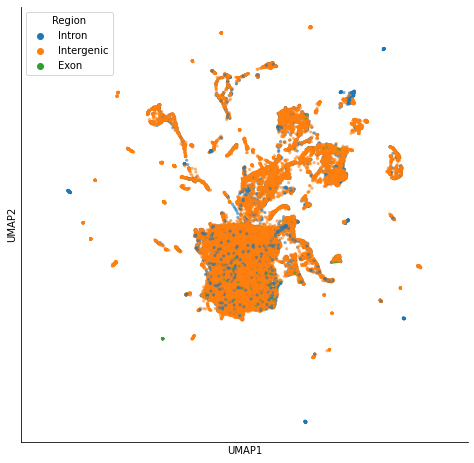

In [20]:
region_order = ["Intron", "Intergenic", "Exon"]


plt.figure(figsize=(8, 8))
g = sns.scatterplot(
    data=windows,
    x="UMAP1",
    y="UMAP2",
    hue="Region",
    hue_order=region_order,
    s=10,
    linewidth=0,
    alpha = 0.6
     #,palette=['grey','grey','red']
)
sns.despine()
plt.xticks([], [])
plt.yticks([], [])
plt.axis('equal');